# Data Import

In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from geopy.distance import geodesic

from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans

from sklearn.neighbors import LocalOutlierFactor

from sklearn.ensemble import IsolationForest

from joblib import dump

from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go

import dask.dataframe as dd

import gc

import pyarrow

In [2]:
dataset_path = '/kaggle/input/sncb-data-augumentation/augumented_cleaned_ar41_for_ulb.csv'

# Check if the file exists before trying to read it
if os.path.exists(dataset_path):
    data = pd.read_csv(dataset_path)

    # Display the basic information and the first few rows of the dataframe
    data_info = data.info()
    data_head = data.head()

    # If you want to print the information to the console
    print(data_info)
    print(data_head)
else:
    print(f"The file {dataset_path} does not exist.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17677337 entries, 0 to 17677336
Data columns (total 42 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   timestamps_UTC      object 
 2   mapped_veh_id       float64
 3   lat                 float64
 4   lon                 float64
 5   RS_E_InAirTemp_PC1  float64
 6   RS_E_InAirTemp_PC2  float64
 7   RS_E_OilPress_PC1   float64
 8   RS_E_OilPress_PC2   float64
 9   RS_E_RPM_PC1        float64
 10  RS_E_RPM_PC2        float64
 11  RS_E_WatTemp_PC1    float64
 12  RS_E_WatTemp_PC2    float64
 13  RS_T_OilTemp_PC1    float64
 14  RS_T_OilTemp_PC2    float64
 15  date                object 
 16  hour                float64
 17  dayofweek           float64
 18  weekday             object 
 19  Distance            float64
 20  Speed               float64
 21  date_hour           object 
 22  datetime_x          object 
 23  weather_main        object 
 24  temp                fl

In [3]:
data = data.drop(['Unnamed: 0', 'dayofweek', 'date_hour'], axis=1)

In [4]:
# data.head(500000).to_csv('mini_augumented_cleaned_ar41_for_ulb.csv', index=True)

# Statistical methods to Label

In [5]:
stopped_threshold = 10  # Speed less than 10 for being stopped
minimum_stopped_minutes = 30  # Minimum duration for stopped status

In [6]:
# Convert timestamps to datetime and sort
data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])
data = data.sort_values('timestamps_UTC')

# Calculate time differences in minutes
data['time_diff'] = data['timestamps_UTC'].diff().dt.total_seconds() / 60.0

# Identify rows where the vehicle is stopped
data['is_stopped'] = data['Speed'] < stopped_threshold

# Forward-fill the 'is_stopped' status only within the groups where the vehicle is stopped
data['stopped_group'] = data['is_stopped'].ne(data['is_stopped'].shift()).cumsum()
data.loc[data['is_stopped'], 'stopped_group'] = data.loc[data['is_stopped'], 'stopped_group']

# Calculate the cumulative stopped time in minutes only for stopped groups
data['cumulative_stopped_time'] = data.groupby('stopped_group')['time_diff'].cumsum().fillna(0)

# Determine the stopped groups that exceed the minimum stopped duration
stopped_groups = data[data['cumulative_stopped_time'] > minimum_stopped_minutes]['stopped_group'].unique()

# Mark the status based on the identified stopped groups
data['status'] = 'running'
data.loc[data['stopped_group'].isin(stopped_groups), 'status'] = 'stopped'


In [7]:
data

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,...,o3,so2,pm2_5,pm10,nh3,time_diff,is_stopped,stopped_group,cumulative_stopped_time,status
10309566,2023-01-23 02:29:50,160.0,51.04,3.69,14.0,15.0,6.0,27.0,802.0,804.0,...,10.82,3.28,8.43,9.75,2.15,NaN,True,1,0.000000,stopped
10309567,2023-01-23 02:30:49,160.0,51.04,3.69,14.0,25.0,6.0,24.0,802.0,804.0,...,8.31,4.11,8.80,10.18,4.50,0.983333,True,1,0.983333,stopped
10309568,2023-01-23 02:31:50,160.0,51.04,3.69,20.0,30.0,6.0,24.0,802.0,804.0,...,8.31,4.11,8.80,10.18,4.50,1.016667,True,1,2.000000,stopped
479843,2023-01-23 02:50:41,106.0,50.41,4.52,41.0,41.0,6.0,3.0,802.0,804.0,...,18.24,1.86,9.10,11.00,3.29,18.850000,True,1,20.850000,stopped
479844,2023-01-23 02:50:48,106.0,50.41,4.52,41.0,41.0,3.0,3.0,802.0,804.0,...,18.24,1.86,9.10,11.00,3.29,0.116667,True,1,20.966667,stopped
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319481,2023-09-13 21:51:55,115.0,50.14,4.50,38.0,36.0,182.0,213.0,802.0,800.0,...,33.62,0.72,1.93,3.68,4.02,0.550000,True,15297,24.583333,running
16731733,2023-09-13 21:51:57,191.0,51.15,4.61,36.0,37.0,424.0,420.0,1501.0,1500.0,...,17.34,0.93,2.38,6.06,8.74,0.033333,True,15297,24.616667,running
3190108,2023-09-13 21:52:16,120.0,50.15,4.50,37.0,31.0,196.0,241.0,801.0,797.0,...,33.62,0.72,1.93,3.68,4.02,0.316667,True,15297,24.933333,running
17418908,2023-09-13 21:52:22,196.0,50.42,4.54,18.0,23.0,690.0,300.0,800.0,795.0,...,30.40,0.86,2.05,3.72,4.12,0.100000,True,15297,25.033333,running


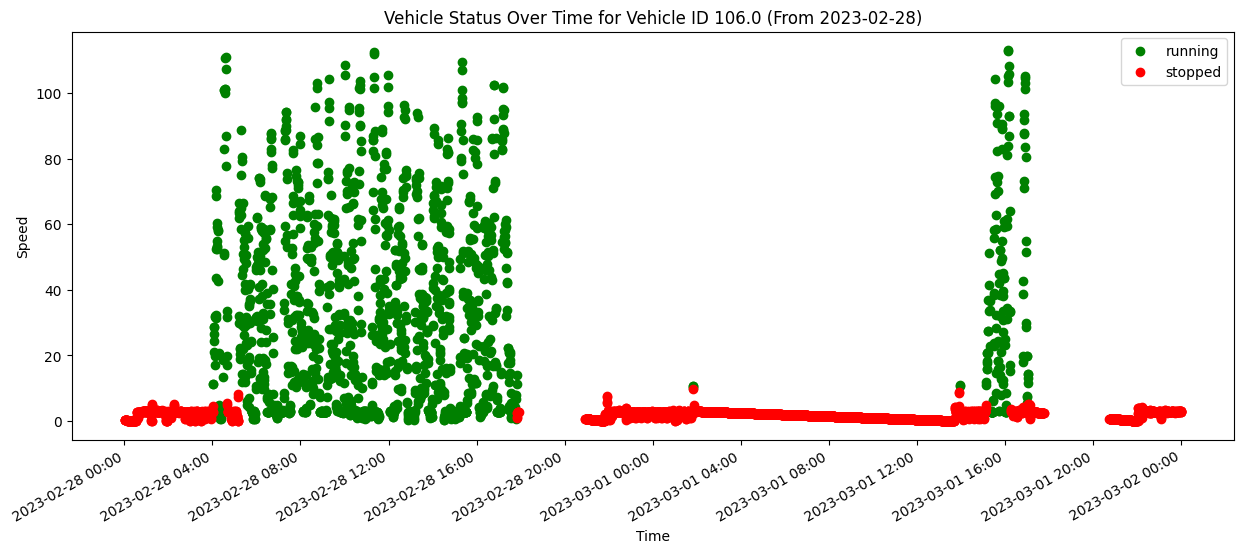

In [8]:
# Define the threshold for a vehicle being stopped and the duration
stopped_threshold = 10  # Speed less than 10 for being stopped
minimum_stopped_minutes = 30  # Minimum duration for stopped status

# Select a specific vehicle ID
specific_veh_id = data['mapped_veh_id'].unique()[1]  
veh_data = data[data['mapped_veh_id'] == specific_veh_id]

# Define the start and end dates for the week you want to display
week_start = pd.to_datetime("2023-02-28")  # Example start date
week_end = week_start + pd.Timedelta(days=2)  # Two days later

# Filter the data for that period
week_data = veh_data[(veh_data['timestamps_UTC'] >= week_start) & (veh_data['timestamps_UTC'] < week_end)]

# Create the plot
plt.figure(figsize=(15, 6))

# Use different colors for running and stopped status
for status, color in [('running', 'green'), ('stopped', 'red')]:
    status_data = week_data[week_data['status'] == status]
    plt.scatter(status_data['timestamps_UTC'], status_data['Speed'], color=color, label=status)

# Set the legend
plt.legend()

# Set the chart title and axis labels
plt.title(f"Vehicle Status Over Time for Vehicle ID {specific_veh_id} (From {week_start.strftime('%Y-%m-%d')})")
plt.xlabel("Time")
plt.ylabel("Speed")

# Format the x-axis to better display dates and times
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=4))
plt.gcf().autofmt_xdate()  # Automatically rotate date labels to prevent overlap

# Show the plot
plt.show()

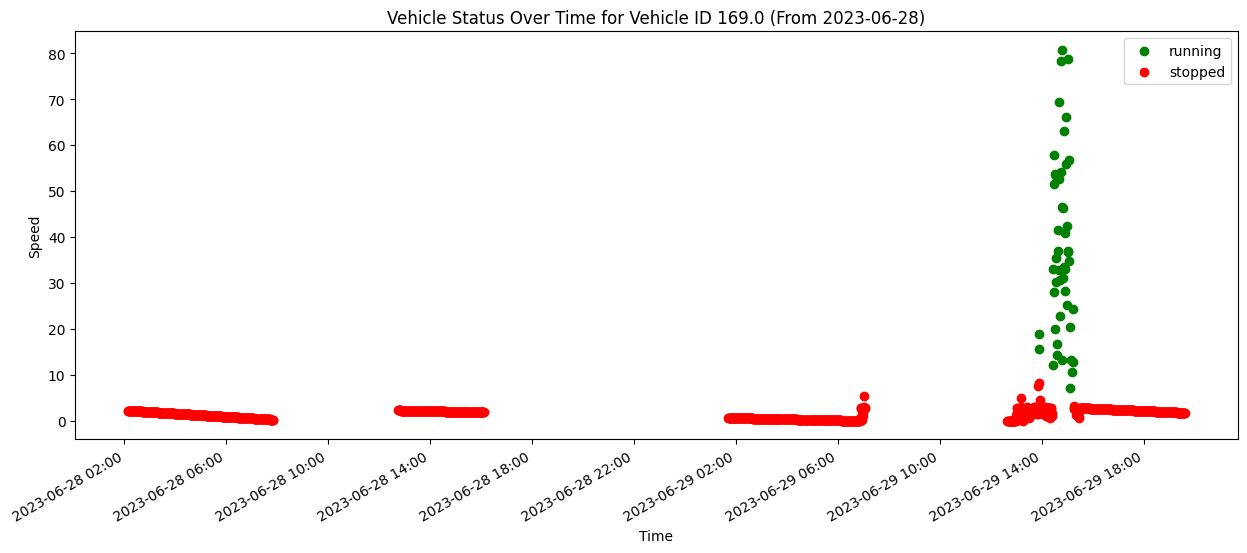

In [9]:
# Define the threshold for a vehicle being stopped and the duration
stopped_threshold = 10  # Speed less than 10 for being stopped
minimum_stopped_minutes = 30  # Minimum duration for stopped status

# Select a specific vehicle ID
specific_veh_id = data['mapped_veh_id'].unique()[50] 
veh_data = data[data['mapped_veh_id'] == specific_veh_id]

# Define the start and end dates for the week you want to display
week_start = pd.to_datetime("2023-06-28")  # Example start date
week_end = week_start + pd.Timedelta(days=2)  # Two days later

# Filter the data for that period
week_data = veh_data[(veh_data['timestamps_UTC'] >= week_start) & (veh_data['timestamps_UTC'] < week_end)]

# Create the plot
plt.figure(figsize=(15, 6))

# Use different colors for running and stopped status
for status, color in [('running', 'green'), ('stopped', 'red')]:
    status_data = week_data[week_data['status'] == status]
    plt.scatter(status_data['timestamps_UTC'], status_data['Speed'], color=color, label=status)

# Set the legend
plt.legend()

# Set the chart title and axis labels
plt.title(f"Vehicle Status Over Time for Vehicle ID {specific_veh_id} (From {week_start.strftime('%Y-%m-%d')})")
plt.xlabel("Time")
plt.ylabel("Speed")

# Format the x-axis to better display dates and times
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=4))
plt.gcf().autofmt_xdate()  # Automatically rotate date labels to prevent overlap

# Show the plot
plt.show()

In [10]:
data = data.drop(['stopped_group', 'is_stopped', 'time_diff'], axis=1)

## Naive Label Anomalous Spot

In [11]:
def label_data(df):
    condition = (
        (df['RS_E_InAirTemp_PC1'] > 65) | (df['RS_E_InAirTemp_PC2'] > 65) |
        (df['RS_E_WatTemp_PC1'] > 100) | (df['RS_E_WatTemp_PC2'] > 100) |
        (df['RS_T_OilTemp_PC1'] > 115) | (df['RS_T_OilTemp_PC2'] > 115)
    )


    df['engine_error_label'] = 0
    df.loc[condition, 'engine_error_label'] = 1

    return df

data = label_data(data)
data

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,...,no,no2,o3,so2,pm2_5,pm10,nh3,cumulative_stopped_time,status,engine_error_label
10309566,2023-01-23 02:29:50,160.0,51.04,3.69,14.0,15.0,6.0,27.0,802.0,804.0,...,0.18,39.41,10.82,3.28,8.43,9.75,2.15,0.000000,stopped,0
10309567,2023-01-23 02:30:49,160.0,51.04,3.69,14.0,25.0,6.0,24.0,802.0,804.0,...,0.30,38.73,8.31,4.11,8.80,10.18,4.50,0.983333,stopped,0
10309568,2023-01-23 02:31:50,160.0,51.04,3.69,20.0,30.0,6.0,24.0,802.0,804.0,...,0.30,38.73,8.31,4.11,8.80,10.18,4.50,2.000000,stopped,0
479843,2023-01-23 02:50:41,106.0,50.41,4.52,41.0,41.0,6.0,3.0,802.0,804.0,...,0.03,17.99,18.24,1.86,9.10,11.00,3.29,20.850000,stopped,0
479844,2023-01-23 02:50:48,106.0,50.41,4.52,41.0,41.0,3.0,3.0,802.0,804.0,...,0.03,17.99,18.24,1.86,9.10,11.00,3.29,20.966667,stopped,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319481,2023-09-13 21:51:55,115.0,50.14,4.50,38.0,36.0,182.0,213.0,802.0,800.0,...,0.00,11.48,33.62,0.72,1.93,3.68,4.02,24.583333,running,0
16731733,2023-09-13 21:51:57,191.0,51.15,4.61,36.0,37.0,424.0,420.0,1501.0,1500.0,...,0.10,27.42,17.34,0.93,2.38,6.06,8.74,24.616667,running,0
3190108,2023-09-13 21:52:16,120.0,50.15,4.50,37.0,31.0,196.0,241.0,801.0,797.0,...,0.00,11.48,33.62,0.72,1.93,3.68,4.02,24.933333,running,0
17418908,2023-09-13 21:52:22,196.0,50.42,4.54,18.0,23.0,690.0,300.0,800.0,795.0,...,0.01,13.19,30.40,0.86,2.05,3.72,4.12,25.033333,running,0


# Isolation Forest

In [12]:
def reduce_mem_usage(df):
    """ Iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if np.issubdtype(col_type, np.number):  # Check if column type is numeric
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type).startswith('int'):
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # You can add more conditions here for other data types if necessary

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [13]:
# Apply the memory reduction
data = reduce_mem_usage(data)

Memory usage of dataframe is 5799.30 MB
Memory usage after optimization is: 2242.17 MB
Decreased by 61.3%


In [14]:
features = [
    'RS_E_InAirTemp_PC1', 'RS_E_InAirTemp_PC2', 
    'RS_E_WatTemp_PC1', 'RS_E_WatTemp_PC2', 
    'RS_T_OilTemp_PC1', 'RS_T_OilTemp_PC2', 
    'Speed', 'lat', 'lon', 'mapped_veh_id', 
    'hour'
]

# Convert 'weekday' to a numerical format
data['weekday'] = pd.to_datetime(data['date']).dt.dayofweek
features.append('weekday')

# Extract feature data
X = data[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply Isolation Forest algorithm
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
outliers = iso_forest.fit_predict(X_scaled)

# Add anomaly labels to the original data
data['IF_outlier'] = outliers

# View the distribution of outliers
outlier_distribution = data['IF_outlier'].value_counts()

print(outlier_distribution)

IF_outlier
 1    17500563
-1      176774
Name: count, dtype: int64


In [15]:
# # Separate numeric and categorical features
# numeric_features = [
#     'RS_E_InAirTemp_PC1', 'RS_E_InAirTemp_PC2', 
#     'RS_E_WatTemp_PC1', 'RS_E_WatTemp_PC2', 
#     'RS_T_OilTemp_PC1', 'RS_T_OilTemp_PC2', 
#     'Speed', 'lat', 'lon', 'mapped_veh_id', 
#     'hour', 'pm10', 'temp_celsius'
# ]
# categorical_features = ['weather_main']

# # Convert 'weekday' to a numerical format
# data['weekday'] = pd.to_datetime(data['date']).dt.dayofweek
# features.append('weekday')

# # Extract feature data
# X = data[features]

# # Standardize numeric features
# scaler = StandardScaler()
# X_numeric_scaled = scaler.fit_transform(data[numeric_features])

# # Encode categorical features
# encoder = OneHotEncoder(sparse=False)
# X_categorical_encoded = encoder.fit_transform(data[categorical_features])

# # Combine numeric and categorical data
# X_combined = np.hstack((X_numeric_scaled, X_categorical_encoded))

# # Parameterization Reasons:
# # n_estimators: 150 - A higher number of trees can improve the model's performance.
# # max_samples: 'auto' - This uses the default behavior of taking min(samples, 256).
# # contamination: 0.001 - Assuming a lower proportion of outliers than default.
# # random_state: 42 - For reproducibility of results.

# # Apply Isolation Forest algorithm
# iso_forest = IsolationForest(n_estimators=150, max_samples='auto', contamination=0.0001, random_state=42)
# outliers = iso_forest.fit_predict(X_combined)

# # Add anomaly labels to the original data
# data['IF_outlier'] = outliers

# # View the distribution of outliers
# outlier_distribution = data['IF_outlier'].value_counts()

# print(outlier_distribution)

In [16]:
dump(iso_forest, 'isolation_forest_model.joblib')

['isolation_forest_model.joblib']

In [17]:
data['IF_outlier'].value_counts()

IF_outlier
 1    17500563
-1      176774
Name: count, dtype: int64

# Evaluation of Isolation Forest

## Statistics Analysis

In [18]:
# Separate the dataset into normal and anomalous data
normal_data = data[data['IF_outlier'] == 1]
anomalous_data = data[data['IF_outlier'] == -1]

# Selecting a few key features for statistical analysis
selected_features = ['RS_E_InAirTemp_PC1', 'RS_E_OilPress_PC1', 'RS_E_RPM_PC1', 'Speed', 'lat', 'lon']

# Computing summary statistics for these features
summary_normal = normal_data[selected_features].describe()
summary_anomalous = anomalous_data[selected_features].describe()

In [19]:
summary_normal

,RS_E_InAirTemp_PC1,RS_E_OilPress_PC1,RS_E_RPM_PC1,Speed,lat,lon
count,17500563.0,1.750056e+07,17500563.0,1.750056e+07,1.750056e+07,1.750056e+07
mean,NaN,NaN,NaN,NaN,NaN,NaN
std,0.0,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00
min,-5.5,4.284668e-01,8.0,0.000000e+00,5.000000e+01,3.570312e+00
25%,22.0,2.030000e+02,798.0,7.890625e-01,5.078125e+01,3.710938e+00
50%,32.0,2.410000e+02,801.0,2.263672e+00,5.100000e+01,3.869141e+00
75%,40.0,3.200000e+02,822.0,3.218750e+00,5.109375e+01,4.539062e+00
max,122.0,6.900000e+02,2308.0,1.198125e+02,5.131250e+01,5.570312e+00


In [20]:
summary_anomalous

,RS_E_InAirTemp_PC1,RS_E_OilPress_PC1,RS_E_RPM_PC1,Speed,lat,lon
count,176774.0,176774.000000,176774.000000,176774.000000,176774.00000,176774.000000
mean,NaN,NaN,NaN,NaN,NaN,NaN
std,0.0,NaN,NaN,0.000000,0.00000,0.000000
min,-5.0,0.600098,6.667969,0.000006,50.06250,3.580078
25%,7.0,17.000000,798.000000,0.437256,50.40625,3.779297
50%,13.0,424.000000,800.000000,1.845703,50.93750,4.460938
75%,20.0,545.000000,803.000000,4.257812,51.00000,4.539062
max,87.0,690.000000,2044.000000,118.812500,51.31250,5.539062


## Visualization

In [21]:
data_mini = data.head(500000)

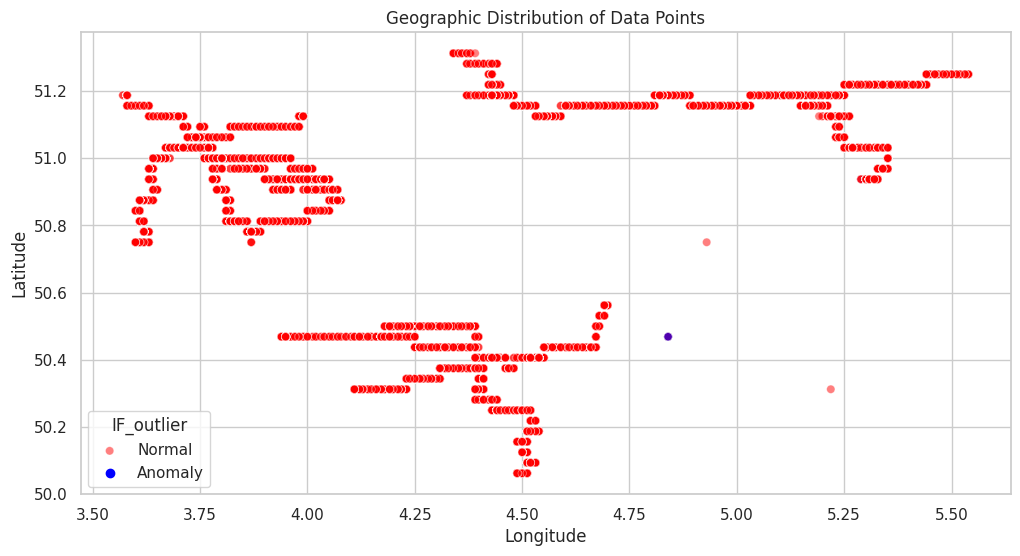

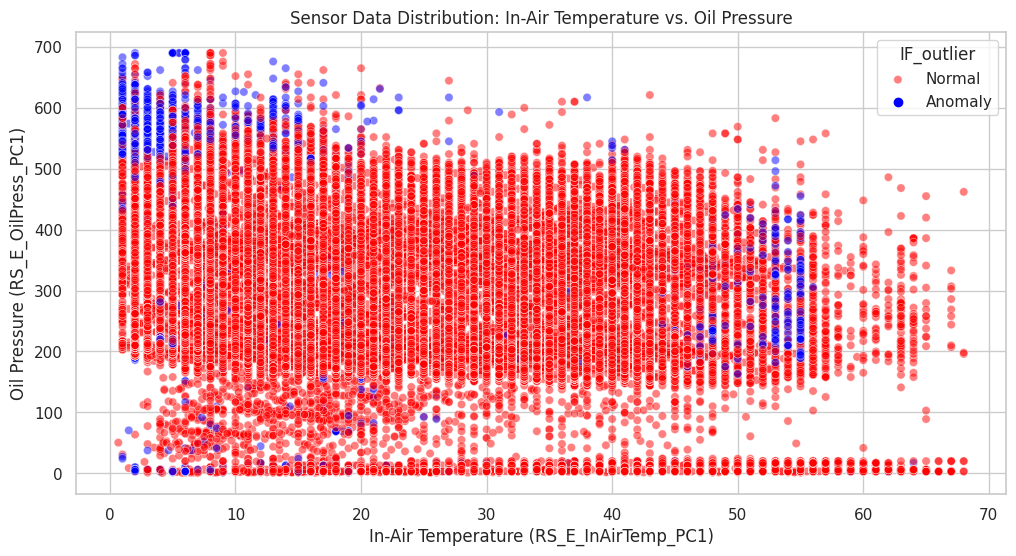

In [22]:
# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# 1. Geographic Distribution
plt.figure(figsize=(12, 6))
sns.scatterplot(x='lon', y='lat', hue='IF_outlier', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Geographic Distribution of Data Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='IF_outlier', labels=['Normal', 'Anomaly'])
plt.show()

# 2. Sensor Data Distribution
plt.figure(figsize=(12, 6))
sns.scatterplot(x='RS_E_InAirTemp_PC1', y='RS_E_OilPress_PC1', hue='IF_outlier', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: In-Air Temperature vs. Oil Pressure')
plt.xlabel('In-Air Temperature (RS_E_InAirTemp_PC1)')
plt.ylabel('Oil Pressure (RS_E_OilPress_PC1)')
plt.legend(title='IF_outlier', labels=['Normal', 'Anomaly'])
plt.show()

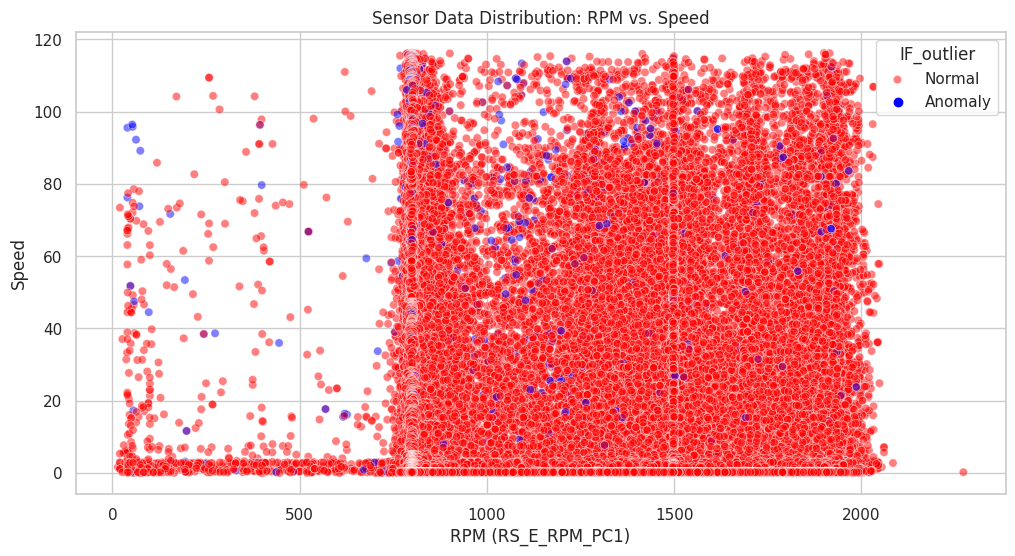

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


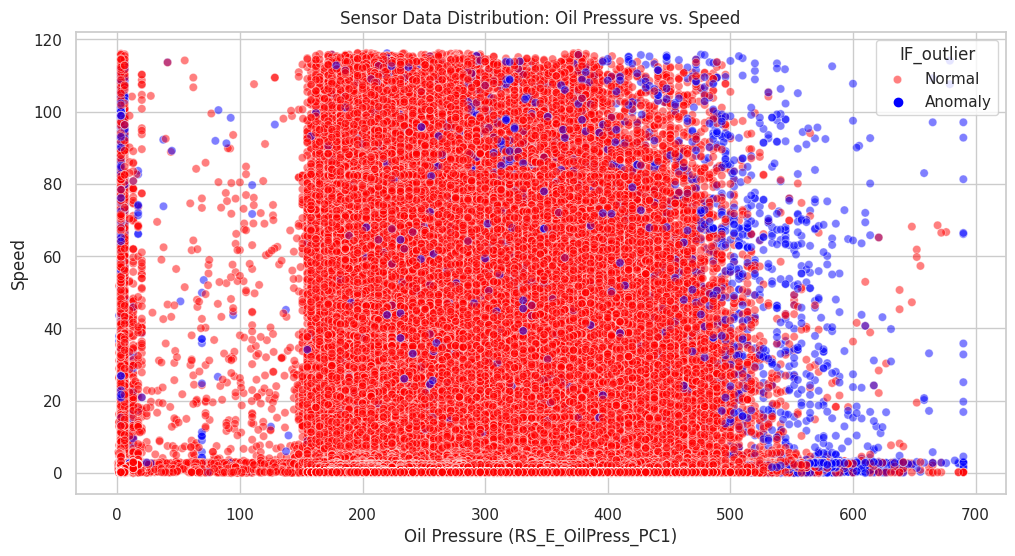

In [23]:
# 3. RPM vs. Speed
plt.figure(figsize=(12, 6))
sns.scatterplot(x='RS_E_RPM_PC1', y='Speed', hue='IF_outlier', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: RPM vs. Speed')
plt.xlabel('RPM (RS_E_RPM_PC1)')
plt.ylabel('Speed')
plt.legend(title='IF_outlier', labels=['Normal', 'Anomaly'])
plt.show()

# 4. Oil Pressure vs. Speed
plt.figure(figsize=(12, 6))
sns.scatterplot(x='RS_E_OilPress_PC1', y='Speed', hue='IF_outlier', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: Oil Pressure vs. Speed')
plt.xlabel('Oil Pressure (RS_E_OilPress_PC1)')
plt.ylabel('Speed')
plt.legend(title='IF_outlier', labels=['Normal', 'Anomaly'])
plt.show()

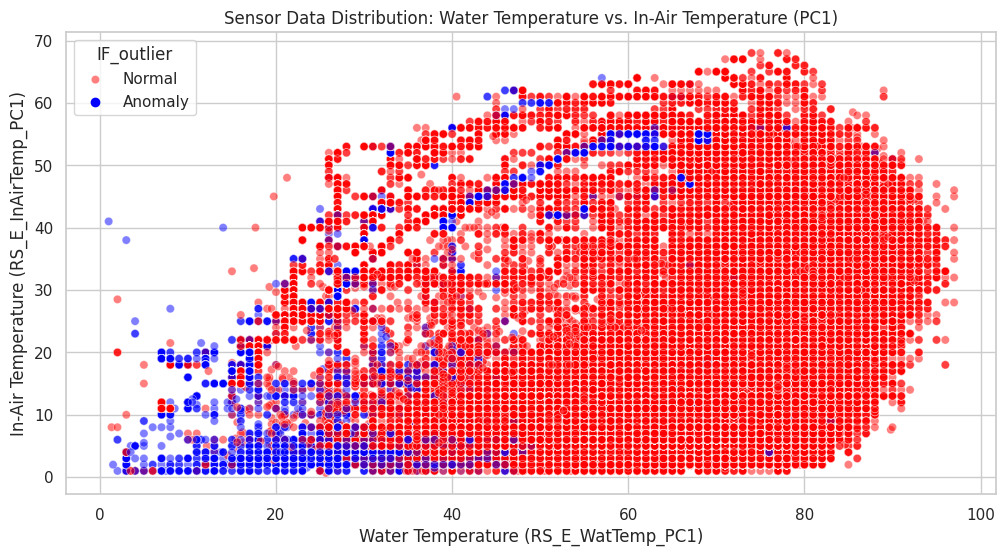

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


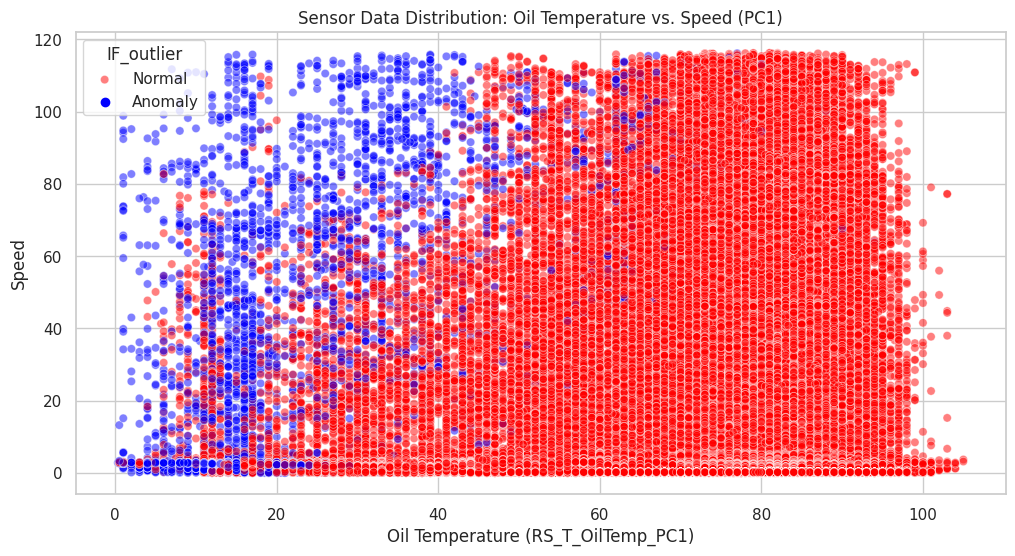

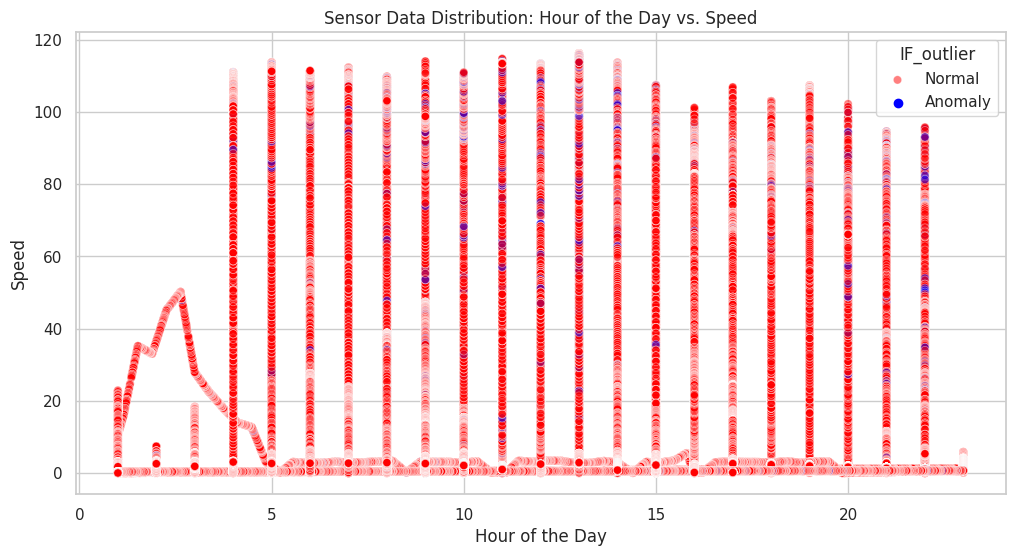

In [24]:
# 5. Water Temperature vs. In-Air Temperature (PC1)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='RS_E_WatTemp_PC1', y='RS_E_InAirTemp_PC1', hue='IF_outlier', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: Water Temperature vs. In-Air Temperature (PC1)')
plt.xlabel('Water Temperature (RS_E_WatTemp_PC1)')
plt.ylabel('In-Air Temperature (RS_E_InAirTemp_PC1)')
plt.legend(title='IF_outlier', labels=['Normal', 'Anomaly'])
plt.show()

# 6. Oil Temperature vs. Speed (PC1)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='RS_T_OilTemp_PC1', y='Speed', hue='IF_outlier', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: Oil Temperature vs. Speed (PC1)')
plt.xlabel('Oil Temperature (RS_T_OilTemp_PC1)')
plt.ylabel('Speed')
plt.legend(title='IF_outlier', labels=['Normal', 'Anomaly'])
plt.show()

# 7. Hour of the Day vs. Speed
plt.figure(figsize=(12, 6))
sns.scatterplot(x='hour', y='Speed', hue='IF_outlier', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: Hour of the Day vs. Speed')
plt.xlabel('Hour of the Day')
plt.ylabel('Speed')
plt.legend(title='IF_outlier', labels=['Normal', 'Anomaly'])
plt.show()

## Contextual Evaluation

# Save to CSV

In [25]:
data.to_csv('labeled_augumented_cleaned_ar41_for_ulb.csv', index=True)